In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
# Definir la función de velocidad terminal Vs(z)
def Vs(z):
    Vs_zmin = 0.05  # Velocidad de caída en zmin (m/s)
    return Vs_zmin * np.exp(0.024 * z)


# Definir el término fuente S(x, y, z, t)
def source_term(H, A, r0, x, y, z, t):
    Q = (H / 0.117)**4.54  # Tasa de emisión de partículas basada en la fórmula de Settle
    f = 1 / (np.pi * (r0 + z / 8)**2)
    S = (A**2 * (1 - z / H) * np.exp(A * (z / H - 1))) / (H * (1 - (1 + A) * np.exp(-A)))
    return Q * S * f


# Condiciones iniciales
def initial_condition(x, y, z):
    return tf.exp(-0.1 * (x**2 + y**2 + z**2))

In [3]:
# Definir la ecuación diferencial parcial de advección-difusión con término temporal
def advection_diffusion(c, x, y, z, t, u_x, u_y, u_z, D_xx, D_yy, D_zz, S):
    c_x, c_y, c_z = tf.gradients(c, [x, y, z])
    c_xx, c_yy, c_zz = tf.gradients(c_x, x)[0], tf.gradients(c_y, y)[0], tf.gradients(c_z, z)[0]
    c_t = tf.gradients(c, t)[0]
    Vs_value = Vs(z)
    return c_t + u_x * c_x + u_y * c_y + Vs_value * c_z - (D_xx * c_xx + D_yy * c_yy + D_zz * c_zz) - S


# Parámetros de la simulación (modificados según los datos reales del volcán Hudson 1991)
x = np.linspace(-10, 10, 50)  # Reducido a 50 puntos
y = np.linspace(-10, 10, 50)
z = np.linspace(-10, 10, 50)
t = np.linspace(0, 10, 50)  # Reducido a 50 puntos
X, Y, Z = np.meshgrid(x, y, z)
X_flatten, Y_flatten, Z_flatten = X.flatten(), Y.flatten(), Z.flatten()


# Parámetros actualizados
u_x, u_y, u_z = 4.1156, -3.6011, 0.2  # Velocidades del viento en m/s
D_xx, D_yy, D_zz = 4000, 4000, 45  # Coeficientes de difusión en m²/s (ajustados)
Vs_zmin = 0.05  # Velocidad terminal de caída en zmin en m/s
r0 = 400  # Radio del cráter en metros
H = 16.0  # Altura máxima de la columna en kilómetros
A = 1.5  # Parámetro adimensional para la posición de máxima concentración

In [4]:
# Modelo de red neuronal con una capa adicional
model = models.Sequential([
    layers.Dense(100, activation='tanh', input_shape=(4,)),
    layers.Dense(100, activation='tanh'),
    layers.Dense(100, activation='tanh'),
    layers.Dense(100, activation='tanh'),  # Capa adicional
    layers.Dense(1)
])


# Compilar el modelo
optimizer = optimizers.Adam(learning_rate=0.001)  # Aprendizaje más lento para mayor precisión
model.compile(optimizer=optimizer, loss='mse')


# Datos de entrenamiento
T_flatten = np.full(X_flatten.shape, 0)  # Tiempo inicial para las condiciones iniciales
inputs = np.stack([X_flatten, Y_flatten, Z_flatten, T_flatten], axis=-1)
targets = initial_condition(X_flatten, Y_flatten, Z_flatten).numpy()


c:\Users\djara\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Entrenamiento de la red neuronal con más épocas
model.fit(inputs, targets, epochs=300, verbose=1, batch_size=128)

Epoch 1/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0065
Epoch 2/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6815e-04
Epoch 3/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9521e-04
Epoch 4/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.2918e-05
Epoch 5/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5317e-04
Epoch 6/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9507e-05
Epoch 7/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1981e-05
Epoch 8/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.3499e-05
Epoch 9/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2129e-05
Epoch 10/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.0740e-05
Epoch 11/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.7884e-05
Epoch 12/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4392e-06
Epoch 13/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.8652e-05   
Epoch 14/300
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss:

3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 595us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 3s 643us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 610us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 610us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 597us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step


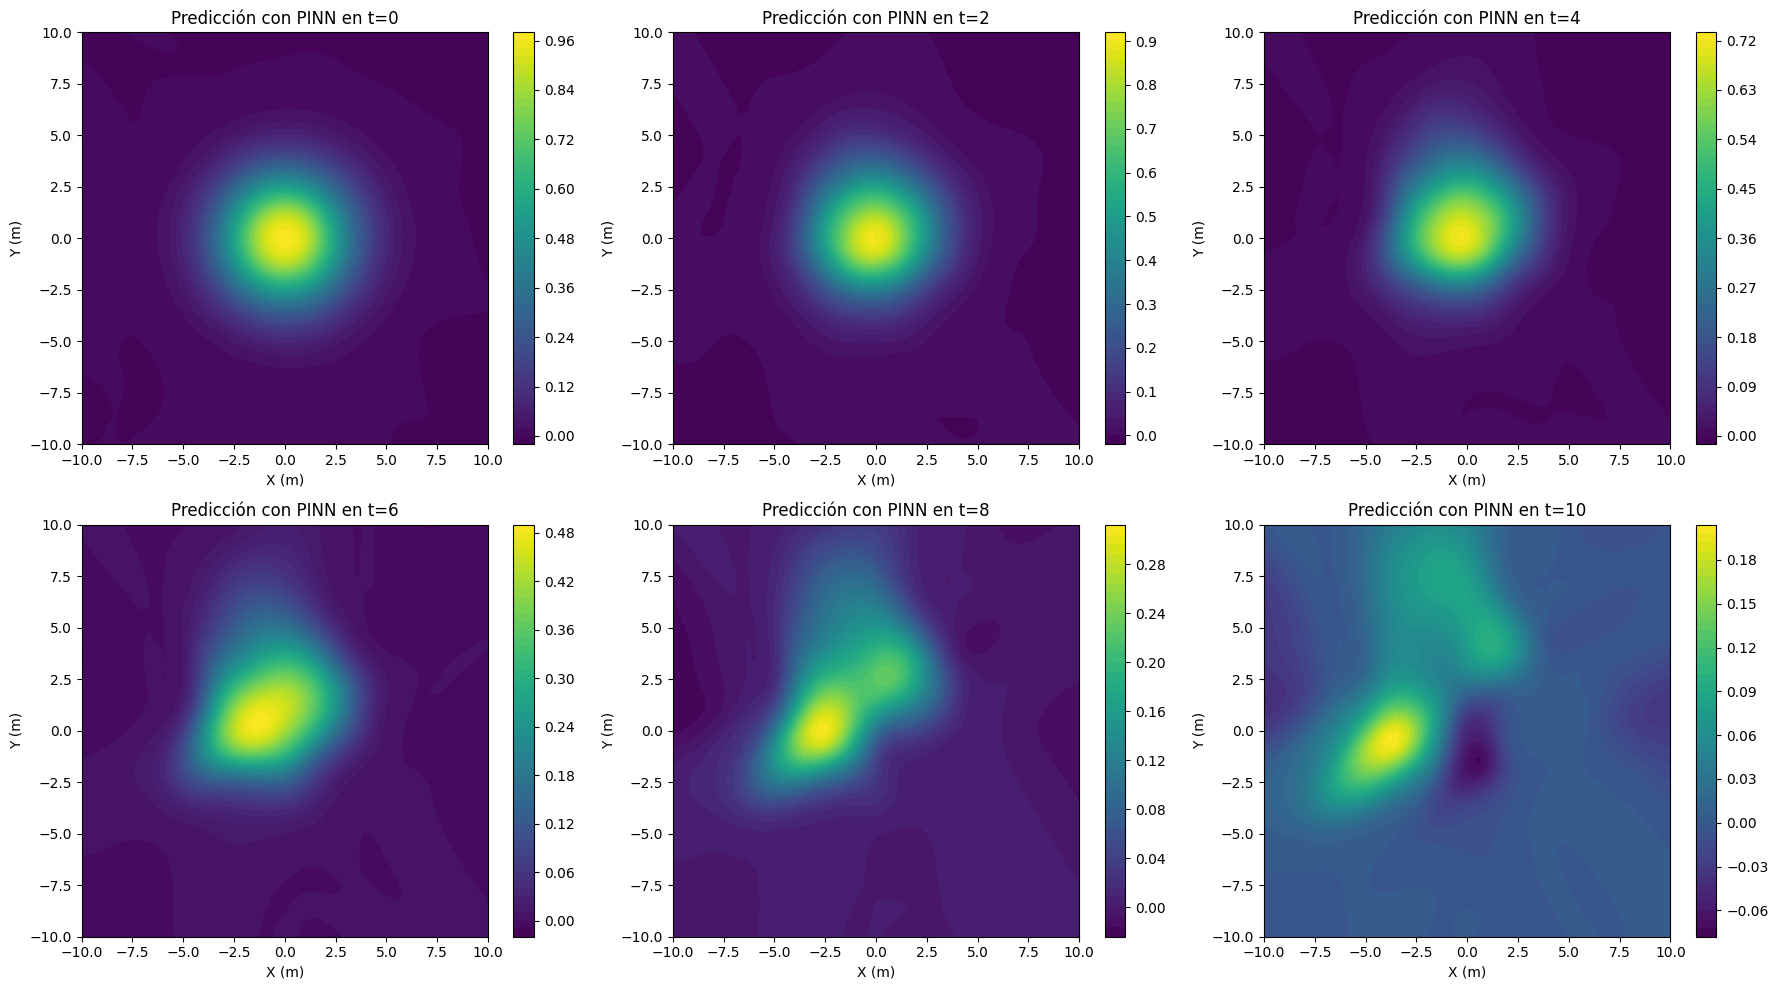

In [6]:
# Predicción con la red entrenada en diferentes momentos
times_to_predict = [0, 2, 4, 6, 8, 10]  # Diferentes tiempos para predecir
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for i, time in enumerate(times_to_predict):
    inputs_time = np.stack([X_flatten, Y_flatten, Z_flatten, np.full(X_flatten.shape, time)], axis=-1)
    predictions = model.predict(inputs_time).reshape((50, 50, 50))


    ax = axs.flatten()[i]
    ax.contourf(X[:, :, 25], Y[:, :, 25], predictions[:, :, 25], levels=50, cmap='viridis')
    ax.set_title(f'Predicción con PINN en t={time}')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    plt.colorbar(ax.contourf(X[:, :, 25], Y[:, :, 25], predictions[:, :, 25], levels=50, cmap='viridis'), ax=ax)


plt.tight_layout()
plt.show()

In [7]:
# Guardar resultados
r = np.sqrt(X_flatten**2 + Y_flatten**2 + Z_flatten**2)
df = pd.DataFrame({'Distancia': r, 'Concentración': predictions.flatten()})
df.to_csv('concentracion_vs_distancia.csv', index=False)

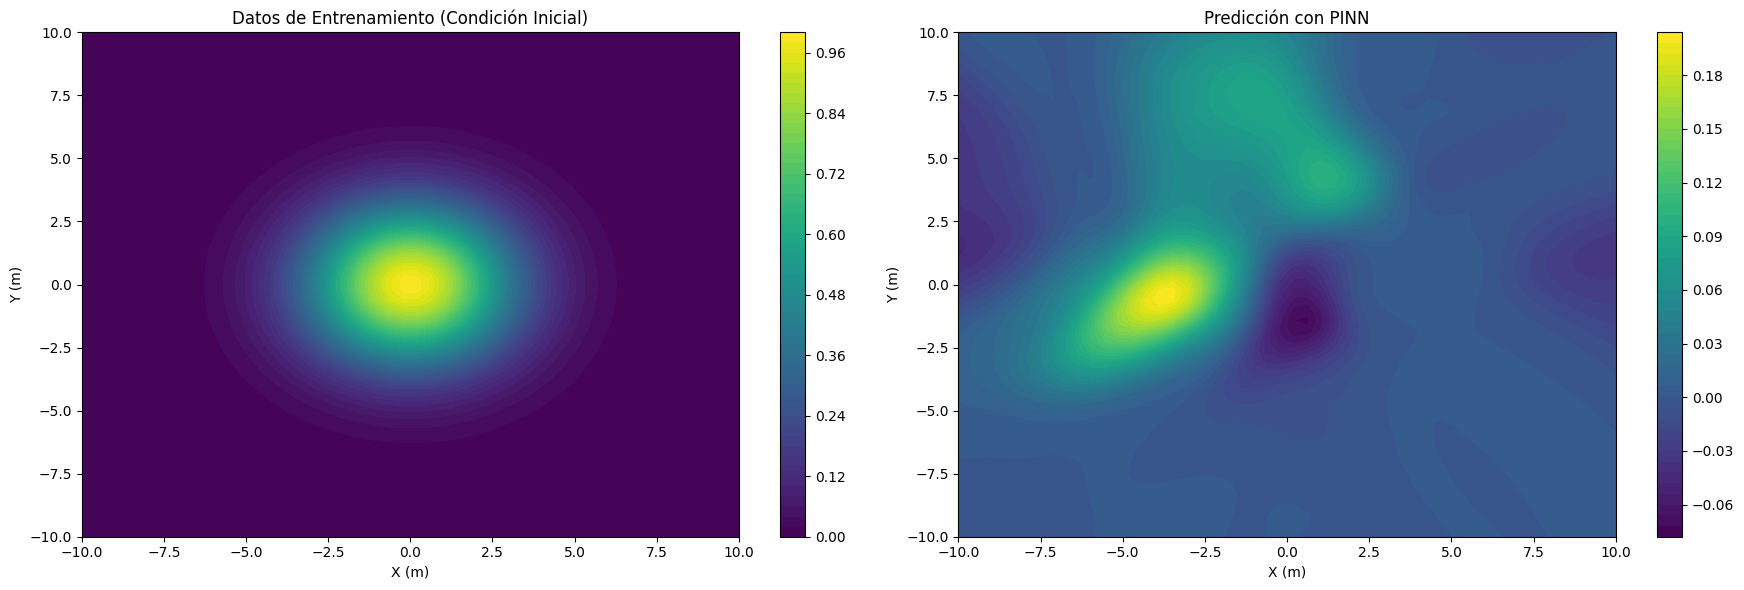

In [8]:
# Gráfico de datos de entrenamiento con la misma escala de color
plt.figure(figsize=(18, 6))


plt.subplot(1, 2, 1)
cont1 = plt.contourf(X[:, :, 25], Y[:, :, 25], targets.reshape(50, 50, 50)[:, :, 25], levels=50, cmap='viridis')
plt.colorbar(cont1)
plt.title('Datos de Entrenamiento (Condición Inicial)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')


# Gráfico de predicción con PINN con la misma escala de color
plt.subplot(1, 2, 2)
cont2 = plt.contourf(X[:, :, 25], Y[:, :, 25], predictions[:, :, 25], levels=50, cmap='viridis')
plt.colorbar(cont2)
plt.title('Predicción con PINN')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')


plt.tight_layout()
plt.show()


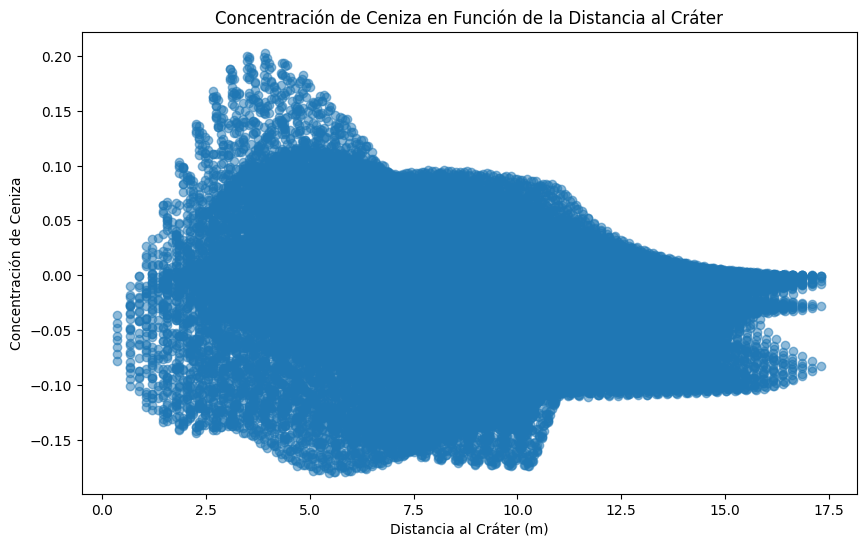

In [9]:
# Calcular la distancia radial al cráter
r = np.sqrt(X_flatten**2 + Y_flatten**2 + Z_flatten**2)


# Guardar los resultados en un archivo .csv en el directorio actual
df = pd.DataFrame({'Distancia': r, 'Concentración': predictions.flatten()})
df.to_csv('concentracion_vs_distancia.csv', index=False)


# Gráfico adicional: Concentración vs Distancia
plt.figure(figsize=(10, 6))
plt.scatter(r, predictions.flatten(), alpha=0.5)
plt.xlabel('Distancia al Cráter (m)')
plt.ylabel('Concentración de Ceniza')
plt.title('Concentración de Ceniza en Función de la Distancia al Cráter')
plt.show()


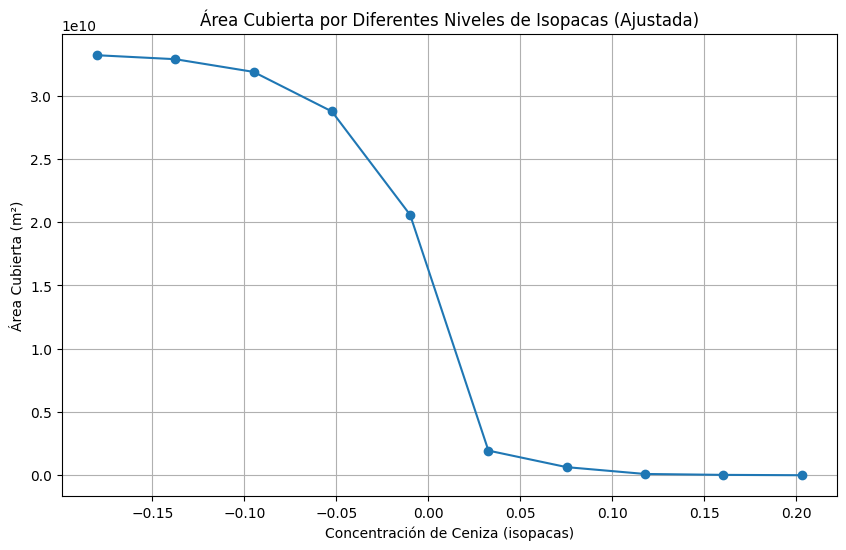

In [10]:
# Calcular el área bajo la curva para diferentes valores de concentración (isopacas)
isopacas = np.linspace(predictions.min(), predictions.max(), num=10)  # Dividir en 10 niveles
areas = []


for iso in isopacas:
    # Calcular el área donde la concentración es mayor que el nivel de isopaca
    area = np.sum(predictions >= iso) * (x[1] - x[0]) * (y[1] - y[0])  # Aproximar el área
    areas.append(area)


# Ajuste del área total basado en la estimación conocida de 150,000 km²
total_area = 150000 * 1e6  # 150,000 km² a m²
areas_normalizadas = [area / np.sum(areas) * total_area for area in areas]


# Graficar el área versus isopacas ajustadas
plt.figure(figsize=(10, 6))
plt.plot(isopacas, areas_normalizadas, marker='o')
plt.xlabel('Concentración de Ceniza (isopacas)')
plt.ylabel('Área Cubierta (m²)')
plt.title('Área Cubierta por Diferentes Niveles de Isopacas (Ajustada)')
plt.grid(True)
plt.show()
